## About 
This notebook is a new way to do the analysis.  Starting from the data and ending at the phi-dependent asymmetries.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rc('font', size=18)
plt.rc('font', family='serif')

AXES = ['x', 'z', 'pt', 'q2']

In [2]:
Z_RANGE = [0.25, 0.75]
N_BINS = 6

### Load Data
Load the data from a compressed csv file.  Dropping the events which are not used in the nominal analysis.  Some unimportant things are discarded and finally, the memory usage is reduced using a code I found online (should give credit here).  Here a useful function is also defined that is used to build the filter for the data for different variations.  This function is used with build_dataframe to get the datasets for analysis after cuts applied.

In [3]:
#data = pd.read_csv('/Users/dmriser/data/inclusive_kaon/inclusive_kaon_small.csv', compression='bz2')
data = pd.read_csv('/Users/davidriser/Data/inclusive/inclusive_kaon_small.csv', compression='bz2')
#data = pd.read_csv('/home/david/data/inclusive/inclusive_kaon.csv', 
#                   compression='bz2')


print('Loaded %d events occupying %d MB of memory.' % (len(data), np.sum(data.memory_usage()/1024**2)))

Loaded 6786077 events occupying 1604 MB of memory.


In [4]:
data.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'helicity', u'meson_id',
       u'missing_mass', u'x', u'q2', u'z', u'pt', u'w', u'eta', u'phi_h',
       u'theta_h', u'p_ele', u'p_mes', u'phi_ele', u'phi_mes', u'theta_ele',
       u'theta_mes', u'dvz', u'alpha', u'dist_ecsf', u'dist_ec_edep',
       u'dist_vz', u'dist_cc_theta', u'dist_dcr1', u'dist_dcr3', u'dist_ecu',
       u'dist_ecv', u'dist_ecw', u'dist_cc'],
      dtype='object')

In [5]:
def build_filter(data,conf=None):
    '''
    data: This is the dataframe, we only need
    it to check that the variable is indeed there.
    
    conf: A dict that contains the 
    cut name and the min, max values
    to be used.  Anything not in this dict
    will be assigned the nominal value.
    
    '''
    
    # When the filter is too long, pandas.DataFrame.query() breaks.
    # Use a vector of filters instead.
    filters = []

    # basic thing that always applies
    filters.append('q2 > 1.0')
    
    if 'w' in data.columns:
        filters.append('w > 2.0')

    if 'meson_id' in data.columns:
        filters.append('meson_id == 321')
    
    # nominal values 
    nominal_conf = {}    
    nominal_conf['alpha']         = [0.05, 1.0]
    nominal_conf['dist_cc']       = [-1.0, 1.0]
    nominal_conf['dist_cc_theta'] = [-1.0, 1.0]
    nominal_conf['dist_dcr1']     = [-1.0, 1.0]
    nominal_conf['dist_dcr3']     = [-1.0, 1.0]
    nominal_conf['dist_ecsf']     = [-1.0, 1.0]
    nominal_conf['dist_ecu']      = [-1.0, 1.0]
    nominal_conf['dist_ecv']      = [-1.0, 1.0]
    nominal_conf['dist_ecw']      = [-1.0, 1.0]
    nominal_conf['dist_ec_edep']  = [-1.0, 1.0]
    nominal_conf['dist_vz']       = [-1.0, 1.0]
    nominal_conf['missing_mass']  = [1.25, 5.0]
    nominal_conf['p_mes']         = [ 0.0, 5.0]
    nominal_conf['dvz']           = [-2.5, 2.5]

        
    # start adding the special options 
    if conf:
        for k,v in conf.iteritems():

            # these have to be valid 
            if len(v) is not 2:
                print('Improper limits for parameter %s' % v)
                return filters
        
            if k in data.columns:
                filters.append('%s > %f and %s < %f' % (k,v[0],k,v[1]))
                print('OPTION: %s, LIMITS: [%f,%f]' % (k,v[0],v[1]))
            else:
                print('Problem adding filter for %s because it is not in the dataframe.columns' % k)

        # now add the default options for those which were not specified
        for k,v in nominal_conf.iteritems():
            if k not in conf.keys():
                if k in data.columns:
                    filters.append('%s > %f and %s < %f ' % (k,v[0],k,v[1])) 
                else:
                    print('Problem adding filter for %s because it is not in the dataframe.columns' % k)
            else:
                print('Not adding nominal cut for %s, it was in the special cuts.' % k)
    
    else:
        for k,v in nominal_conf.iteritems():
            if k in data.columns:
                print('OPTION: %s, LIMITS: [%f,%f]' % (k,v[0],v[1]))
                filters.append('%s > %f and %s < %f ' % (k,v[0],k,v[1])) 
            else:
                print('Problem adding filter for %s because it is not in the dataframe.columns' % k)        
    
    return filters

In [6]:
def build_dataframe(data, filters):
    CHUNK_SIZE = 4
       
    if len(filters) < CHUNK_SIZE:
        return data.query(' and '.join(filters))
    
    else:
        d = data.copy(deep=True)
        
        for i in range(0, len(filters), CHUNK_SIZE):
            f = filters[i:i + CHUNK_SIZE]
            d.query(' and '.join(f), inplace=True)

        return d

In [7]:
IMPORTANT_AXES = ['alpha', 'dist_cc', 'dist_cc_theta', 
                  'dist_dcr1', 'dist_dcr3', 'dist_ecsf',
                  'dist_ec_edep', 'dist_ecu', 'dist_ecv', 
                  'dist_ecw','dist_vz', 'helicity',
                  'missing_mass', 'p_mes', 'phi_h', 
                  'pt', 'q2', 'x', 'z', 'dvz']

data.dropna(how='any', inplace=True)

for col in data.columns:
    if col not in IMPORTANT_AXES:
        data.drop(col, axis=1, inplace=True)
        
print('Loaded %d events occupying %d MB of memory.' % (len(data), np.sum(data.memory_usage()/1024**2)))

Loaded 6759179 events occupying 1082 MB of memory.


In [8]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
                       
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
    return props, NAlist

In [9]:
data, _ = reduce_mem_usage(data)
print('Loaded %d events occupying %d MB of memory.' % (len(data), np.sum(data.memory_usage()/1024**2)))

Loaded 6759179 events occupying 547 MB of memory.


### Load Binning 
Binning is created by making equal statistics in each bin, for each axis.

In [10]:
def bin_by_quantile(data, axis=None, n_bins=None):

    # find minimum and maximum 
    axis_range = np.min(data[axis]), np.max(data[axis])
    
    # step in quantile to do binning 
    quantile_step = 1.0/n_bins
    
    bins = []
    for index in range(n_bins+1):
        bins.append(data[axis].quantile(index*quantile_step))
        
    return np.array(bins)

In [11]:
nominal_filter = build_filter(data)
nominal_data   = build_dataframe(data, nominal_filter)
print('Loaded %d events occupying %d MB of memory.' % (len(nominal_data), np.sum(nominal_data.memory_usage()/1024**2)))

OPTION: dist_dcr3, LIMITS: [-1.000000,1.000000]
OPTION: dist_dcr1, LIMITS: [-1.000000,1.000000]
OPTION: dist_vz, LIMITS: [-1.000000,1.000000]
OPTION: dvz, LIMITS: [-2.500000,2.500000]
OPTION: dist_cc_theta, LIMITS: [-1.000000,1.000000]
OPTION: dist_ecw, LIMITS: [-1.000000,1.000000]
OPTION: dist_ec_edep, LIMITS: [-1.000000,1.000000]
OPTION: dist_ecsf, LIMITS: [-1.000000,1.000000]
OPTION: p_mes, LIMITS: [0.000000,5.000000]
OPTION: alpha, LIMITS: [0.050000,1.000000]
OPTION: missing_mass, LIMITS: [1.250000,5.000000]
OPTION: dist_ecu, LIMITS: [-1.000000,1.000000]
OPTION: dist_cc, LIMITS: [-1.000000,1.000000]
OPTION: dist_ecv, LIMITS: [-1.000000,1.000000]
Loaded 3385238 events occupying 274 MB of memory.


In [12]:
#import pickle as pkl

bins = {}

for axis in AXES:
    
    if axis is not 'z':
        bins[axis] = bin_by_quantile(nominal_data.query('z > %f and z < %f' % (Z_RANGE[0], Z_RANGE[1])), 
                                                        axis=axis, n_bins=N_BINS)    
    else:
        bins[axis] = bin_by_quantile(nominal_data, axis=axis, n_bins=N_BINS) 

### Calculate Nominal Result
This part of the code generates a dataframe which contains the measurement results for the "best" parameters.  I will also add a global index to the dataframe.  An important parameter is defined which restricts the range of z added to non-z axes.  It is called z_range.

In [13]:
def convert_bin_limits_to_centers(limits):
    centers = []
    for i in range(len(limits)-1):
            centers.append(limits[i] + 0.5*(limits[i+1]-limits[i]))
    return np.array(centers)

In [14]:
def get_asymmetry_df(data, axis, n_bins,
                     beam_pol=0.749,
                     beam_pol_unc=0.03,
                     n_phi_bins=12,
                     custom_bin_limits=None):

    # setup the binning for the phi axis
    phi_bin_limits = np.linspace(-180, 180, n_phi_bins+1)

    # covert bin limits to central positions for plotting
    phi_bin_centers = convert_bin_limits_to_centers(phi_bin_limits)

    if custom_bin_limits is not None:
        axis_range = list([custom_bin_limits[0], custom_bin_limits[-1]])
        bin_limits = custom_bin_limits
        n_bins = len(custom_bin_limits)-1

    else:
        # calculate range of binned axis
        axis_range = data[axis].quantile(0.001), data[axis].quantile(0.999)

        # create bin limits for binning up the dataframe
        bin_limits = np.linspace(axis_range[0], axis_range[1], n_bins+1)

    results = []
    for index in range(len(bin_limits)-1):

        # setup a string used to query for data in this bin
        # and the corresponding title for this bin
        bin_query = ('%s > %f and %s < %f' % (axis, bin_limits[index], axis, bin_limits[index+1]))
        bin_title = ('%s $\in [%.2f, %.2f]$' % (axis, bin_limits[index], bin_limits[index+1]))

        # query the data for this bin
        data_subset = data.query(bin_query)

        # get histograms for positive and negative helicity
        pos_counts, _ = np.histogram(data_subset[data_subset.helicity > 0].phi_h, bins=phi_bin_limits)
        neg_counts, _ = np.histogram(data_subset[data_subset.helicity < 0].phi_h, bins=phi_bin_limits)

        # calculate the asymmetry and the error
        diff = np.array(pos_counts-neg_counts, dtype=np.float32)
        total = np.array(pos_counts+neg_counts, dtype=np.float32)
        asymmetry = diff/total/beam_pol
        error = np.sqrt((1-asymmetry**2)/total)
        sys0 = beam_pol_unc*np.abs(asymmetry)
        
        result = {}
        result['axis']       = [axis] * len(pos_counts)
        result['axis_min']   = [bin_limits[index]] * len(pos_counts)
        result['axis_max']   = [bin_limits[index+1]] * len(pos_counts)
        result['axis_bin']   = [index] * len(pos_counts)
        result['counts_pos'] = pos_counts
        result['counts_neg'] = neg_counts
        result['value']      = asymmetry
        result['stat']       = error
        result['sys_0']      = sys0
        result['phi']        = phi_bin_centers
        result['phi_bin']    = np.arange(len(phi_bin_centers))
        results.append(pd.DataFrame(result))

    return pd.concat(results)

In [15]:
def get_results(data, axes, bins):
    df_store = []

    for axis in axes:
        if axis is not 'z':
            df_store.append( get_asymmetry_df(data=data.query('z > %f and z < %f' % (Z_RANGE[0], Z_RANGE[1])), 
                                                axis=axis, 
                                              n_bins=len(bins[axis]),
                                              custom_bin_limits=bins[axis],
                                             n_phi_bins=12) 
                           )
        else:
            df_store.append( get_asymmetry_df(data=data, 
                                                axis=axis, 
                                              n_bins=len(bins[axis]),
                                              custom_bin_limits=bins[axis],
                                             n_phi_bins=12) 
                           )
     
    for df in df_store:
        df['global_index'] = df.phi_bin + df.axis_bin * len(np.unique(df.phi_bin))

    return pd.concat(df_store)

In [16]:
results = {}
results['nominal'] = get_results(nominal_data, AXES, bins)

In [17]:
# Free the memory! 
del nominal_data 

### Vary Parameters
Now I will vary some parameters and store those results as well.

In [18]:
variations          = {}

variations['alpha'] = {}
variations['alpha'][-2] = [ 0.02, 1.0]
variations['alpha'][-1] = [0.035, 1.0]
variations['alpha'][ 0] = [ 0.05, 1.0]
variations['alpha'][ 1] = [ 0.07, 1.0]
variations['alpha'][ 2] = [ 0.09, 1.0]

variations['dist_cc'] = {}
variations['dist_cc'][-2] = [-1.2, 1.2]
variations['dist_cc'][-1] = [-1.1, 1.1]
variations['dist_cc'][ 0] = [-1.0, 1.0]
#variations['dist_cc'][ 1] = [-0.9, 0.9]
#variations['dist_cc'][ 2] = [-0.8, 0.8]

variations['dist_dcr1'] = {}
variations['dist_dcr1'][-2] = [-1.2, 1.2]
variations['dist_dcr1'][-1] = [-1.1, 1.1]
variations['dist_dcr1'][ 0] = [-1.0, 1.0]
variations['dist_dcr1'][ 1] = [-0.9, 0.6]
variations['dist_dcr1'][ 2] = [-0.8, 0.5]

variations['dist_dcr3'] = {}
variations['dist_dcr3'][-2] = [ -1.2, 1.2]
variations['dist_dcr3'][-1] = [ -1.1, 1.1]
variations['dist_dcr3'][ 0] = [ -1.0, 1.0]
variations['dist_dcr3'][ 1] = [-0.95, 0.65]
variations['dist_dcr3'][ 2] = [-0.90, 0.45]

variations['dist_ecsf'] = {}
variations['dist_ecsf'][-2] = [-1.2, 1.2]
variations['dist_ecsf'][-1] = [-1.1, 1.1]
variations['dist_ecsf'][ 0] = [-1.0, 1.0]
variations['dist_ecsf'][ 1] = [-0.9, 0.9]
variations['dist_ecsf'][ 2] = [-0.8, 0.8]

variations['dist_ec_edep'] = {}
variations['dist_ec_edep'][-2] = [-1.2, 1.2]
variations['dist_ec_edep'][-1] = [-1.1, 1.1]
variations['dist_ec_edep'][ 0] = [-1.0, 1.0]
variations['dist_ec_edep'][ 1] = [-0.9, 0.9]
variations['dist_ec_edep'][ 2] = [-0.8, 0.8]

variations['dist_ecu'] = {}
variations['dist_ecu'][-2] = [-1.2, 1.2]
variations['dist_ecu'][-1] = [-1.1, 1.1]
variations['dist_ecu'][ 0] = [-1.0, 1.0]
variations['dist_ecu'][ 1] = [-0.9, 0.9]
variations['dist_ecu'][ 2] = [-0.8, 0.8]

variations['dist_ecv'] = {}
variations['dist_ecv'][-2] = [ -1.2, 1.2]
variations['dist_ecv'][-1] = [ -1.1, 1.1]
variations['dist_ecv'][ 0] = [ -1.0, 1.0]
variations['dist_ecv'][ 1] = [-0.55, 0.98]
variations['dist_ecv'][ 2] = [-0.45, 0.96]

variations['dist_ecw'] = {}
variations['dist_ecw'][-2] = [ -1.2, 1.2]
variations['dist_ecw'][-1] = [ -1.1, 1.1]
variations['dist_ecw'][ 0] = [ -1.0, 1.0]
variations['dist_ecw'][ 1] = [ -0.6, 0.98]
variations['dist_ecw'][ 2] = [-0.55, 0.96]

variations['dist_vz'] = {}
variations['dist_vz'][-2] = [-1.2, 1.2]
variations['dist_vz'][-1] = [-1.1, 1.1]
variations['dist_vz'][ 0] = [-1.0, 1.0]
variations['dist_vz'][ 1] = [-0.9, 0.9]
variations['dist_vz'][ 2] = [-0.8, 0.8]

'''
The following variation is added only after using the 
results of the function called momentum_check.  These
values are used to add the difference between the two 
as a systematic uncertainty.
'''
variations['p_mes'] = {}
variations['p_mes'][-1] = [0.0, 2.5]
variations['p_mes'][ 0] = [0.0, 5.0]

In [19]:
for par in variations.keys():
    results[par] = {}
    
    for index in variations[par].keys():
        print('\nDoing  %.3f < %s %.3f' % (variations[par][index][0], par, 
                                         variations[par][index][1]))

        # get these cut values 
        temp_dict = {}
        temp_dict[par] = variations[par][index]
        
        # get data 
        temp_filter = build_filter(data, temp_dict)
        temp_data   = build_dataframe(data, temp_filter)
        results[par][index] = get_results(temp_data, AXES, bins)
        del temp_data


Doing  -1.000 < dist_dcr3 1.000
OPTION: dist_dcr3, LIMITS: [-1.000000,1.000000]
Not adding nominal cut for dist_dcr3, it was in the special cuts.

Doing  -0.950 < dist_dcr3 0.650
OPTION: dist_dcr3, LIMITS: [-0.950000,0.650000]
Not adding nominal cut for dist_dcr3, it was in the special cuts.

Doing  -0.900 < dist_dcr3 0.450
OPTION: dist_dcr3, LIMITS: [-0.900000,0.450000]
Not adding nominal cut for dist_dcr3, it was in the special cuts.

Doing  -1.100 < dist_dcr3 1.100
OPTION: dist_dcr3, LIMITS: [-1.100000,1.100000]
Not adding nominal cut for dist_dcr3, it was in the special cuts.

Doing  -1.200 < dist_dcr3 1.200
OPTION: dist_dcr3, LIMITS: [-1.200000,1.200000]
Not adding nominal cut for dist_dcr3, it was in the special cuts.

Doing  -1.000 < dist_dcr1 1.000
OPTION: dist_dcr1, LIMITS: [-1.000000,1.000000]
Not adding nominal cut for dist_dcr1, it was in the special cuts.

Doing  -0.900 < dist_dcr1 0.600
OPTION: dist_dcr1, LIMITS: [-0.900000,0.600000]
Not adding nominal cut for dist_dcr1,

### Stability Checks
The following section is used to check the stability of the analysis.  First I will split the dataset into sub-samples and compute the nominal result on all sub-samples.  The results will be compared by using a chi-2 test.

In [20]:
def metric(y1, y2, dy1, dy2):
    return 0.5*np.average((y2-y1)**2/(0.5*(dy1+dy2)**2))
    #return 1-np.sum((y2-y1)**2)/np.sum((y2+y1)**2)
    
def chi2(y_true, y_pred, y_err):
    return np.average((y_true-y_pred)**2/y_err**2)

In [21]:
def subset_check(data, axes, bins, n_subsets=2):
    
    subsets = np.array_split(data, n_subsets)
    
    results = []
    for subset in subsets:
        results.append(get_results(subset, axes, bins))
    
    scores = []
    for i in range(n_subsets):
        for j in range(i+1,n_subsets):            
            if i is not j:
                score = metric(results[i].value, results[j].value, 
                               results[i].stat, results[j].stat)
                scores.append(score)
                
    return scores

In [22]:
nominal_filter = build_filter(data)
nominal_data   = build_dataframe(data, nominal_filter)
subset_scores  = subset_check(data, AXES, bins, 4)

OPTION: dist_dcr3, LIMITS: [-1.000000,1.000000]
OPTION: dist_dcr1, LIMITS: [-1.000000,1.000000]
OPTION: dist_vz, LIMITS: [-1.000000,1.000000]
OPTION: dvz, LIMITS: [-2.500000,2.500000]
OPTION: dist_cc_theta, LIMITS: [-1.000000,1.000000]
OPTION: dist_ecw, LIMITS: [-1.000000,1.000000]
OPTION: dist_ec_edep, LIMITS: [-1.000000,1.000000]
OPTION: dist_ecsf, LIMITS: [-1.000000,1.000000]
OPTION: p_mes, LIMITS: [0.000000,5.000000]
OPTION: alpha, LIMITS: [0.050000,1.000000]
OPTION: missing_mass, LIMITS: [1.250000,5.000000]
OPTION: dist_ecu, LIMITS: [-1.000000,1.000000]
OPTION: dist_cc, LIMITS: [-1.000000,1.000000]
OPTION: dist_ecv, LIMITS: [-1.000000,1.000000]


In [23]:
from scipy.stats import binom

In [24]:
def randomize_helicity(data):
    states = [-1, 1]
    return np.random.choice(states, size=len(data))

def random_helicity_check(data, axes, bins, n_trials):
    scores  = []
    results = []

    for i in range(n_trials):
        data['helicity'] = randomize_helicity(data)
        result = get_results(data, axes, bins)

        # add the probability of this result or less 
        # to the dataframe
        result['p_value'] = 1-np.abs(binom.cdf(result.counts_pos, 
                                  result.counts_neg+result.counts_pos, 
                                  0.5) - binom.cdf(result.counts_neg, 
                                  result.counts_neg+result.counts_pos, 
                                  0.5) 
                               )
            
        y_true = np.zeros(len(result))
        scores.append(chi2(result.value, y_true, result.stat))
        results.append(result)
        
    return scores, results

In [25]:
hel_scores, hel_results = random_helicity_check(nominal_data, AXES, bins, 1)

In [26]:
def momentum_check(data, axes, bins, p_limits):
    
    results = []
    
    for index in range(len(p_limits)):
        query_string = 'p_mes > %f and p_mes < %f' % (p_limits[index][0], p_limits[index][1])
        results.append(get_results(data.query(query_string), axes, bins))
        
    return results

In [27]:
p_limits = np.array([[0.0, 5.0], [0.0, 2.5]])
p_results = momentum_check(data, AXES, bins, p_limits)

In [28]:
del nominal_data

### Calculate Systematic Errors
Using the variation of parameters, the difference between each configuration and nominal will be calculated.  A column is then added to the nominal results for each source of systematic error which contains the largest shift from nominal for each global bin (this is done with the largest_shift routine).

In [29]:
for conf in results.keys():

    if conf is not 'nominal':
        for val in results[conf].keys():
            
            # Is this safe?  They could be in different orders.  It has been checked visually. 
            results[conf][val]['shift'] = results['nominal']['value'] - results[conf][val]['value']

In [30]:
def get_global_bin_data(nominal, variations, axis, global_index):
              
    d = nominal.query('axis == "%s" and global_index == %d' % (axis, global_index))
    
    v = {}
    for var in variations.keys():
        v[var] = variations[var].query('axis == "%s" and global_index == %d' % (axis, global_index))
    
    found_data = True
    
    if len(d) is not 1:
        found_data = False
        
    for vi in v.keys():
        if len(v[vi]) is not 1:
            found_data = False
    
    if not found_data:
        print('Trouble finding data for global index %d' % global_index)
        return 

    # success
    return d,v

def get_largest_shifts(results):
    
    '''
    inputs 
    ------
    results - A dictionary generated above which contains results of 
    nominal running, as well as parameter variations.  
    
    outputs 
    -------
    
    '''
    
    # we need to do the process for each axis independently
    active_axes = np.unique(results['nominal'].axis)
    n_global    = len(np.unique(results['nominal'].global_index))
    
    # something to store the result in 
    df_dict = {}
    df_dict['axis']         = []
    df_dict['global_index'] = []
    
    # somewhere to correlate the variation name with the column name
    column_dict = {}
    
    # going though the different variations 
    i_par = 1
    for par in results.keys(): 
        if par is not 'nominal':
            # setup somewhere to store this 
            column_title = 'sys_%d' % i_par
            df_dict[column_title] = []    
            column_dict[column_title] = par
            i_par += 1
            
    for axis in active_axes:
        for index in range(n_global):
            df_dict['axis'].append(axis)
            df_dict['global_index'].append(index)
            
            i_par = 1
            for par in results.keys(): 
                if par is not 'nominal':
                    # setup somewhere to store this 
                    column_title = 'sys_%d' % i_par
                
                    d,v = get_global_bin_data(results['nominal'], results[par], axis, index)        
                    current_shifts = [val['shift'].values[0] for key,val in v.iteritems()]
                    df_dict[column_title].append(np.max(np.abs(current_shifts)))
                    i_par += 1
    
    # now add them in quadrature
    df_dict['sys_total'] = []
    for i in range(len(df_dict['global_index'])):
        
        bin_total = 0.0
        for k in df_dict.keys():
            if 'sys' in k and 'total' not in k:
                bin_total += df_dict[k][i]**2
        
        df_dict['sys_total'].append(bin_total)
    
    df_dict['sys_total'] = np.sqrt(df_dict['sys_total'])
    df = pd.DataFrame(df_dict)
    return df, column_dict

In [31]:
def get_linearized_error(results):
    
    '''
    inputs 
    ------
    results - A dictionary generated above which contains results of 
    nominal running, as well as parameter variations.  
    
    outputs 
    -------
    
    '''
    
    # we need to do the process for each axis independently
    active_axes = np.unique(results['nominal'].axis)
    n_global    = len(np.unique(results['nominal'].global_index))
    
    # something to store the result in 
    df_dict = {}
    df_dict['axis']         = []
    df_dict['global_index'] = []
    
    # somewhere to correlate the variation name with the column name
    column_dict = {}
    
    # going though the different variations 
    i_par = 1
    for par in results.keys(): 
        if par is not 'nominal':
            # setup somewhere to store this 
            column_title = 'sys_%d' % i_par
            df_dict[column_title] = []    
            column_dict[column_title] = par
            i_par += 1
            
    for axis in active_axes:
        for index in range(n_global):
            df_dict['axis'].append(axis)
            df_dict['global_index'].append(index)
            
            i_par = 1
            for par in results.keys(): 
                if par is not 'nominal':
                    # setup somewhere to store this 
                    column_title = 'sys_%d' % i_par
                
                    d,v = get_global_bin_data(results['nominal'], results[par], axis, index)        

                    if 1 in v.keys() and -1 in v.keys():
                        delta = (v[1]['value'].values[0]-v[-1]['value'].values[0])
                    elif 0 in v.keys() and -1 in v.keys():
                        delta = (v[0]['value'].values[0]-v[-1]['value'].values[0])
                    elif 0 in v.keys() and 1 in v.keys():
                        delta = (v[1]['value'].values[0]-v[0]['value'].values[0])
                    else:
                        raise ValueError('For parameter %s I dont know how to linearize, there are no shifts?' % par)
                        
                    df_dict[column_title].append(delta)
                    i_par += 1
    
    # now add them in quadrature
    df_dict['sys_total'] = []
    for i in range(len(df_dict['global_index'])):
        
        bin_total = 0.0
        for k in df_dict.keys():
            if 'sys' in k and 'total' not in k:
                bin_total += df_dict[k][i]**2
        
        df_dict['sys_total'].append(bin_total)
    
    df_dict['sys_total'] = np.sqrt(df_dict['sys_total'])
    df = pd.DataFrame(df_dict)
    return df, column_dict

In [32]:
#shift_df, var_to_col = get_largest_shifts(results)
shift_df, var_to_col = get_linearized_error(results)

In [33]:
var_to_col['sys_0'] = 'beam_pol'

This line is very important.  I am adding the shifts into the nominal dataframe, but you must be careful to merge it using the axis and the global_index.

In [34]:
results['nominal'] = pd.merge(left=results['nominal'], 
                              right=shift_df, 
                              on=['axis', 'global_index']
                             )

In [35]:
results['nominal'].head()

,axis,axis_bin,axis_max,axis_min,counts_neg,counts_pos,phi,phi_bin,stat,sys_0,...,sys_11,sys_2,sys_3,sys_4,sys_5,sys_6,sys_7,sys_8,sys_9,sys_total
0,x,0,0.158947,0.106729,38532,38335,-165.0,0,0.003607,0.000103,...,-0.000730,-0.000335,-0.000370,-0.000218,-0.000515,0.000743,0.000487,0.000888,0.001713,0.002411
1,x,0,0.158947,0.106729,14922,14332,-135.0,1,0.005845,0.000808,...,0.002775,0.000278,0.003964,-0.001936,-0.003439,0.000514,-0.007592,-0.001158,-0.007794,0.013076
2,x,0,0.158947,0.106729,30165,29318,-105.0,2,0.004099,0.000570,...,-0.000181,0.000268,0.000493,-0.000369,0.000406,0.001411,-0.001918,-0.000892,-0.001294,0.003054
3,x,0,0.158947,0.106729,14194,13862,-75.0,3,0.005969,0.000474,...,0.001407,-0.000443,0.008663,-0.000322,-0.001627,-0.003913,0.000562,-0.000402,0.000201,0.009940
4,x,0,0.158947,0.106729,13924,13129,-45.0,4,0.006075,0.001177,...,0.000340,-0.000423,-0.000903,-0.002565,-0.000930,-0.002803,-0.000396,0.000338,-0.004133,0.005912


In [36]:
def print_table(results, naming_dict):
    
    sys_cols = [c for c in results.columns if 'sys' in c and 'total' not in c]
    
    for col in sys_cols:
        print('mean: %f, stat: %f, parameter: %s' % (np.average(np.abs(results[col])), 
                                                     np.average(results.stat), naming_dict[col])
             )
             

In [37]:
print_table(results['nominal'], var_to_col)

mean: 0.000629, stat: 0.005810, parameter: beam_pol
mean: 0.001553, stat: 0.005810, parameter: dist_dcr3
mean: 0.000667, stat: 0.005810, parameter: dist_ecw
mean: 0.000683, stat: 0.005810, parameter: dist_ecv
mean: 0.001108, stat: 0.005810, parameter: dist_dcr1
mean: 0.002151, stat: 0.005810, parameter: dist_ecu
mean: 0.001513, stat: 0.005810, parameter: alpha
mean: 0.000858, stat: 0.005810, parameter: dist_cc
mean: 0.001331, stat: 0.005810, parameter: dist_ec_edep
mean: 0.001755, stat: 0.005810, parameter: p_mes
mean: 0.000982, stat: 0.005810, parameter: dist_ecsf
mean: 0.001874, stat: 0.005810, parameter: dist_vz


### Visualization
The results are visualized.  

In [38]:
def plot_results(results, axis, plot_sys=False):
    
    d      = results.query('axis == "%s"' % axis)
    n_bins = len(np.unique(d.axis_bin))
    n_col  = 3
    n_row  = np.ceil(n_bins/n_col)+1

    # these are uniform width
    phi_width = np.repeat(float(360.0/len(np.unique(d.phi_bin))), len(np.unique(d.phi_bin)))
    phi_edges = np.linspace(-180,180,len(np.unique(d.phi_bin)))
    plt.figure(figsize=(4*n_col, 3*n_row))
    
    for index in range(n_bins):
        dsub = d.query('axis_bin == %d' % index)
        plt.subplot(n_row, n_col, index+1)
        plt.errorbar(x=dsub.phi, y=dsub.value, yerr=dsub.stat, 
                    linestyle='', marker='o', color='black')
        
        if 'sys_total' in dsub.columns and plot_sys is True:
            plt.bar(phi_edges, height=dsub.sys_total, width=phi_width, bottom=0.0, 
                    edgecolor='black', color='red', alpha=0.65, hatch='///', 
                    label='systematic error', align='edge')
            
        plt.axhline(0.0, linestyle='--',
                    linewidth=1, color='black', alpha=0.4)
        
        plt.xlim([-180,180])
        plt.ylim([-0.08, 0.08])
        
        plt.xlabel('$\phi_h$')
        plt.ylabel('BSA')
        
    plt.tight_layout()

def plot_sys(results, axis):
    
    d      = results.query('axis == "%s"' % axis)
    n_bins = len(np.unique(d.axis_bin))
    n_col  = 3
    n_row  = np.ceil(n_bins/n_col)+1

    sys_columns = [c for c in d.columns if 'sys' in c and 'total' not in c]
    
    # these are uniform width
    phi_width = np.repeat(float(360.0/len(np.unique(d.phi_bin))), len(np.unique(d.phi_bin)))
    phi_edges = np.linspace(-180,180,len(np.unique(d.phi_bin)))
    plt.figure(figsize=(4*n_col, 3*n_row))
    
    for index in range(n_bins):
        dsub = d.query('axis_bin == %d' % index)
        plt.subplot(n_row, n_col, index+1)
        
        total = np.zeros(len(np.unique(d.phi_bin)))
        for sys_i in sys_columns:
            plt.bar(phi_edges, height=dsub[sys_i], width=phi_width, bottom=total, label=sys_i, align='edge')
            total += dsub[sys_i]
            
        plt.axhline(0.0, linestyle='--',
                    linewidth=1, color='black', alpha=0.4)
        
        plt.xlim([-180,180])
        plt.ylim([0.0, 0.35])
        
    plt.tight_layout()

def plot_sys_bar(results, name_dict, axis):    
    
    plt.figure(figsize=(16,9))
    
    # get subset of data
    d = results.query('axis == "%s"' % axis)
    
    # list of systematics 
    sys_columns = [c for c in d.columns if 'sys' in c and 'total' not in c]
    names = [name_dict[c] for c in sys_columns]
    
    errs = [np.average(d[xp].values**2) for xp in sys_columns]
    errs = np.array(errs)
    errs /= np.sum(errs)
    
    n_sys = len(sys_columns)

    plt.barh(np.arange(n_sys), errs, tick_label=names,
            color='red', hatch='///', edgecolor='black')
    
    plt.xlabel('Fraction of total systematic uncertainty')
    
def compare_results(results1, results2, axis):
    
    d1     = results1.query('axis == "%s"' % axis)
    d2     = results2.query('axis == "%s"' % axis)
    n_bins = len(np.unique(d1.axis_bin))
    n_col  = 3
    n_row  = np.ceil(n_bins/n_col)+1

    # these are uniform width
#    phi_width = float(360.0/len(np.unique(d.phi_bin)))
    
    plt.figure(figsize=(4*n_col, 4*n_row))
    
    for index in range(n_bins):
        dsub1 = d1.query('axis_bin == %d' % index)
        dsub2 = d2.query('axis_bin == %d' % index)
        plt.subplot(n_row, n_col, index+1)
        plt.errorbar(x=dsub1.phi, y=dsub1.value, yerr=dsub1.stat, 
                    linestyle='', marker='o', color='red')
        plt.errorbar(x=dsub2.phi, y=dsub2.value, yerr=dsub2.stat, 
                    linestyle='', marker='o', color='blue')
       
        plt.axhline(0.0, linestyle='--',
                    linewidth=1, color='black', alpha=0.4)
        
        plt.xlim([-180,180])
        plt.ylim([-0.15, 0.15])
        
    plt.tight_layout()
    
def plot_counts(results, axis):
    
    d      = results.query('axis == "%s"' % axis)
    n_bins = len(np.unique(d.axis_bin))
    n_col  = 3
    n_row  = np.ceil(n_bins/n_col)+1

    # these are uniform width
    phi_width = float(360.0/len(np.unique(d.phi_bin)))
    
    plt.figure(figsize=(4*n_col, 4*n_row))
    
    for index in range(n_bins):
        dsub = d.query('axis_bin == %d' % index)
        plt.subplot(n_row, n_col, index+1)
        plt.bar(dsub.phi, dsub.counts_pos, width=phi_width, 
                color='red', alpha=0.3)
        plt.bar(dsub.phi, dsub.counts_neg, width=phi_width, 
                color='blue', alpha=0.3)        
      
        plt.axhline(0.0, linestyle='--',
                    linewidth=1, color='black', alpha=0.4)
        
        plt.xlim([-180,180])
        
    plt.tight_layout()
    
def get_shifts(d, v):

    x = []
    y = []
    yerr = []
    # key is the variation number
    # value is the dataframe 
    for key, val in v.iteritems():
        x.append(key)
        y.append(val['value'].values[0])
        yerr.append(np.sqrt(np.abs(val['stat'].values[0]**2 - d['stat'].values[0]**2)))
     
    
    x = np.array(x)
    y = np.array(y,       dtype=np.float32)
    yerr = np.array(yerr, dtype=np.float32)
    
    return x, y, yerr

def plot_shifts(nominal, variations, axis, global_index):
    d,v = get_global_bin_data(nominal, variations, axis, global_index)
    x, y, yerr = get_shifts(d, v)
    
    low = d.value.values[0]-d.stat.values[0]
    up = d.value.values[0]+d.stat.values[0]
    
    # set color of bar 
    color = 'green'
    for i in range(len(y)):
        if (y[i] > low) and (y[i] < up):
            continue
        else:
            color='red'
    
    plt.errorbar(x=x, y=y, yerr=yerr, 
                 linestyle='', marker='o', color='black')
    plt.axhspan(low, up, 
                color=color, alpha=0.2)
   # plt.ylim([-0.06, 0.06])
    plt.title('(phi,axis)=(%d,%d)' % (d.phi_bin, d.axis_bin))

def plot_2d_shifts(nominal, variations, axis):
    
    nglobal = len(np.unique(nominal.global_index))
    nphi    = len(np.unique(nominal.phi_bin))
    naxis   = len(np.unique(nominal.axis_bin))
    nvars   = len(variations.keys())
    
    if nphi*naxis is not nglobal:
        print('big problems')
        return
    
    val = np.zeros([nvars, nglobal])
    
    for index in range(nglobal):
        d,v = get_global_bin_data(nominal, variations, axis, index)
        x, y, yerr = get_shifts(d, v)
    
        for i,yp in enumerate(y):
            val[i][index] = yp
    
    plt.figure(figsize=(16,16))
    plt.imshow(val)
    
def plot_grid_shifts(nominal, variations, axis):
    
    nglobal = len(np.unique(nominal.global_index))
    nphi = len(np.unique(nominal.phi_bin))
    
    #ncol = nphi
    ncol = 6
    nrow = 1+np.ceil(nglobal/ncol)
    
    plt.figure(figsize=(4*ncol,3*nrow))
    for i in range(nglobal):
        plt.subplot(nrow,ncol,i+1)
        plot_shifts(nominal, variations, axis, i)
        
    plt.tight_layout()
    
def plot_variation_limits(data, variations):
    
    n_vars = len(variations.keys())
    n_col = 3
    n_row = 1 + np.ceil(n_vars/n_col)
    
    plt.figure(figsize=(4*n_col, 3*n_row))
    
    index = 1
    for k,v in variations.iteritems():
        plt.subplot(n_row, n_col, index)
        plt.hist(data[k], histtype='stepfilled', bins=50,
                alpha=0.65, edgecolor='black', color='red', hatch='///');
        plt.xlabel(k)
        index += 1

        for key, values in variations[k].iteritems():
            color = 'black'
            
            if key is 0:
                color = 'green'
            
            plt.axvline(values[0], color=color)
            plt.axvline(values[1], color=color)
        
    plt.tight_layout()
    
def plot_subset_check(scores):
    plt.hist(scores, bins=20, histtype='stepfilled',
            color='red', edgecolor='black', hatch='///', alpha=0.7)
    plt.xlabel('Metric')
    plt.ylabel('Occurances')
    plt.title('Subset Scores')
    
def plot_helicity_bin(nominal, results, axis, global_index):
    bin_results = []
    val = []
    err = []
    
    nominal_data = nominal.query('axis == "%s" and global_index == %d' % (axis, global_index))
    
    for r in results:
        bin_results.append(r.query('axis == "%s" and global_index == %d' % (axis, global_index)))
        
    for b in bin_results:
        val.append(b.value.values[0])
        err.append(b.stat.values[0])
        
    val = np.array(val, dtype=np.float32)
    err = np.array(err, dtype=np.float32)
    
    plt.hist(val, bins=np.linspace(-0.1, 0.1, 40), histtype='stepfilled',
            color='yellow', edgecolor='red', hatch='///');
    plt.axvspan(-1*nominal_data.stat.values[0], nominal_data.stat.values[0], alpha=0.4, color='red')
    
    
def plot_grid_helicity_check(nominal, results, axis):
    
    nglobal = len(np.unique(nominal.global_index))
    nphi = len(np.unique(nominal.phi_bin))
    
    #ncol = nphi
    ncol = 6
    nrow = 1+np.ceil(nglobal/ncol)
    
    plt.figure(figsize=(4*ncol,3*nrow))
    for i in range(nglobal):
        plt.subplot(nrow,ncol,i+1)
        plot_helicity_bin(nominal, results, axis, i)
        
    plt.tight_layout()

    
def plot_helicity_prob(results, axis):
    
    r = results.query('axis == "%s"' % axis)
    
    phi_width = np.repeat(float(360.0/len(np.unique(r.phi_bin))), len(np.unique(r.phi_bin)))
    phi_edges = np.linspace(-180,180,len(np.unique(r.phi_bin)))

    n_bins = len(np.unique(r.axis_bin))
    n_col  = 3
    n_row  = 2*(1+np.ceil(n_bins/n_col))
    
    plt.figure(figsize=(5*n_col, 2*n_row))

    for i in range(n_bins):
        pad = i if i < n_col else n_col + i
        
        plt.subplot(n_row, n_col, n_col+pad+1)
        plt.bar(phi_edges, height=r.query('axis_bin == %d' % i).p_value, 
               width=phi_width, bottom=0.0, edgecolor='black', color='red', 
                alpha=0.65, hatch='///', label='CDF Value', align='edge')
        plt.ylim([0.0,1.0])
        plt.ylabel('p value')
    
    for i in range(n_bins):
        pad = i if i < n_col else n_col + i

        plt.subplot(n_row, n_col, pad+1)
        plt.errorbar(r.query('axis_bin == %d' % i).phi, 
                     r.query('axis_bin == %d' % i).value, 
                     r.query('axis_bin == %d' % i).stat, color='black',marker='o',
                    linestyle='')
        plt.axhline(0.0, color='black', alpha=0.4, linestyle='--')
        plt.ylim([-0.06,0.08])
        plt.ylabel('BSA')
        
    plt.tight_layout()
    
from matplotlib.colors import LogNorm

def plot_kinematics(data):
    plt.figure(figsize=(12,8))
    
    plt.subplot(2,2,1)
    plt.hist2d(data.z, data.pt, bins=100, cmap='rainbow')
    plt.colorbar()
    plt.xlabel('z')
    plt.ylabel('$P_T$')
    
    plt.subplot(2,2,2)
    plt.hist(data.x, bins=100, histtype='stepfilled', hatch='///',
            color='white', edgecolor='black') 
    plt.xlabel('x')
    
    plt.subplot(2,2,3)
    plt.hist(data.z, bins=100, histtype='stepfilled', hatch='///',
            color='white', edgecolor='black') 
    plt.xlabel('z')


    plt.subplot(2,2,4)
    plt.hist(data.q2, bins=100, histtype='stepfilled', hatch='///',
            color='white', edgecolor='black')  
    plt.xlabel('$Q^2$')

    
    plt.tight_layout()
    
def plot_binning(data, bins):
    
    latex = {}
    latex['x'] = 'x'
    latex['z'] = 'z'
    latex['q2'] = '$Q^2$'
    latex['pt'] = '$P_T$'
    
    n_axes = len(bins.keys())
    n_col = 2
    n_row = 1+np.ceil(n_axes/n_col)
    
    plt.figure(figsize=(4*n_col, 4*n_row))

    for index, axis in enumerate(bins.keys()):
        plt.subplot(n_row, n_col, index+1)
        plt.hist(data[axis], bins=100, histtype='stepfilled',
                color='orange', edgecolor='black', alpha=0.5)
    
        plt.xlabel(latex[axis])
        for b in bins[axis]:
            plt.axvline(b, color='black')
            
    plt.tight_layout()
    
def plot_momentum_check(results, axis, p_limits):
    
    colors = ['red', 'blue', 'black', 'green']
    
    df_store = []
    for r in results:
        df_store.append(r.query('axis == "%s"' % axis))
    
    if len(df_store) is 2:
        r = lambda x1, x2: 1 - np.sum((x2-x1)**2)/np.sum((x2+x1)**2)
        m = r(df_store[0].value, df_store[1].value)
    
    plt.figure(figsize=(16,9))
    for index, df in enumerate(df_store):
        
        label_string = '$p \in [%.2f, %.2f]$' % (p_limits[index][0], p_limits[index][1])
        plt.errorbar(df.global_index, df.value, df.stat, 
                     linestyle='', marker='.', label=label_string,
                    color=colors[index])
    
    plt.ylim([-0.06, 0.06])
    plt.axhline(0.0, linestyle='--', linewidth=1, color='black', alpha=0.7)
    plt.ylabel('BSA')
    plt.xlabel('Global bin index')
    plt.legend()
    
    if len(df_store) is 2:
        plt.text(2, 0.05, '$R = %.2f$' % m)

def scatter_two_results(result1, result2, axis):
    
    d1 = result1.query('axis == "%s"' % axis)
    d2 = result2.query('axis == "%s"' % axis)
    axis_val = d1.axis_min + 0.5*(d1.axis_max - d1.axis_min)
    
    plt.figure(figsize=(16,9))
    plt.scatter(d1.value, d2.value, 
                marker='o', alpha=0.75, c=axis_val, cmap='viridis')
    plt.colorbar()

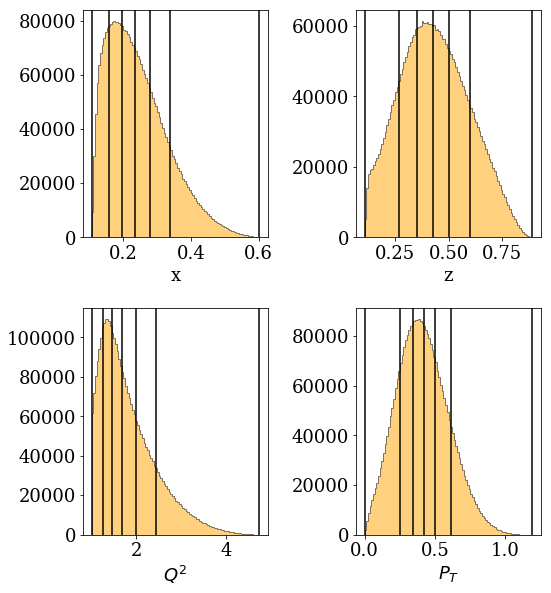

In [39]:
plot_binning(build_dataframe(data, nominal_filter),
             bins)
plt.savefig('image/binning.pdf', bbox_inches='tight')

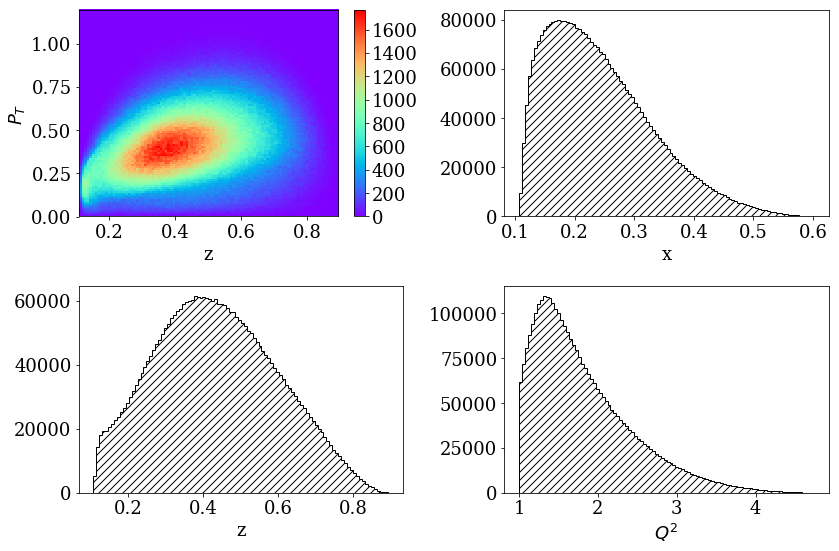

In [40]:
plot_kinematics(build_dataframe(data, nominal_filter))
plt.savefig('image/kinematics.pdf', bbox_inches='tight')

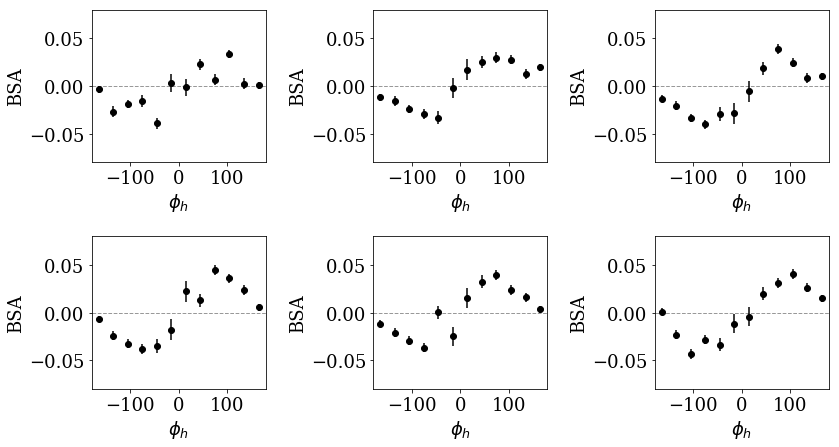

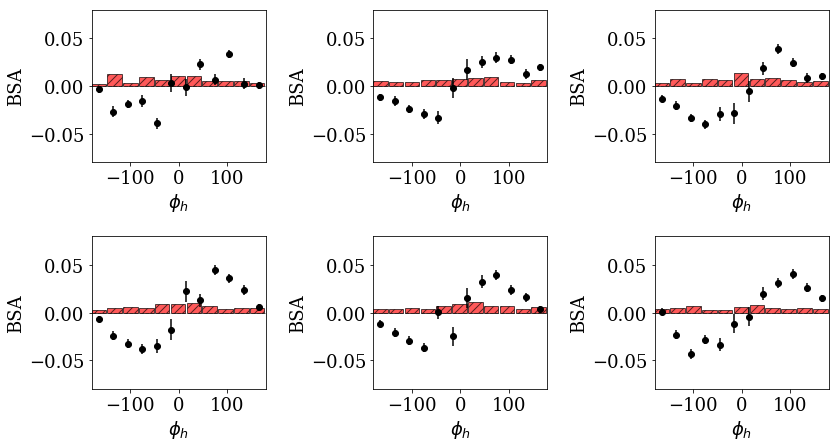

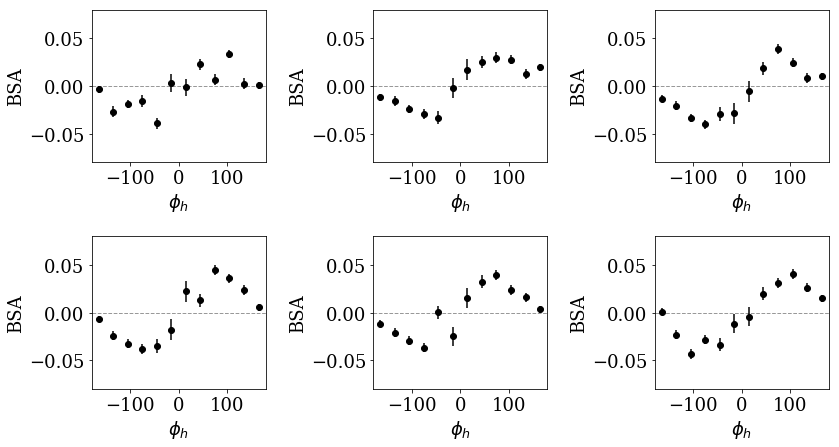

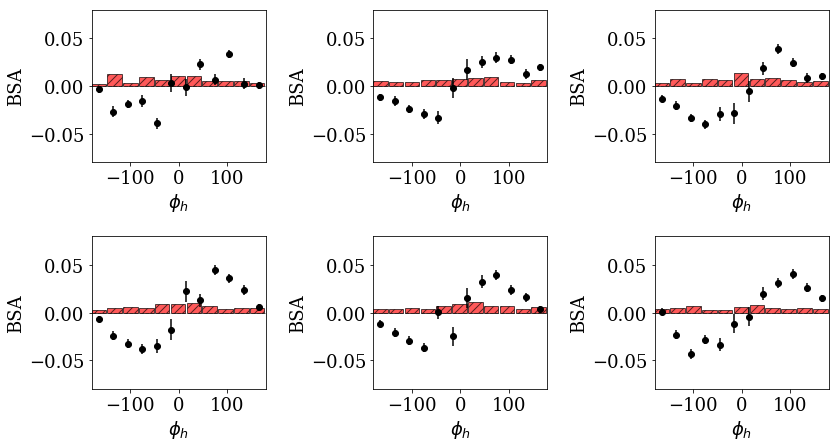

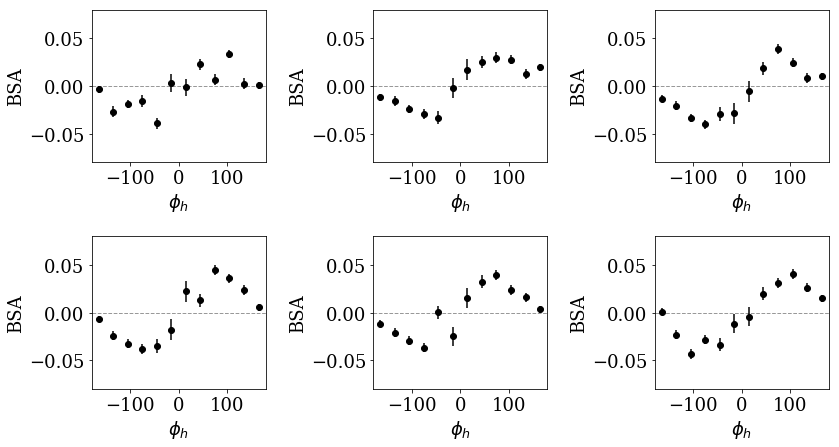

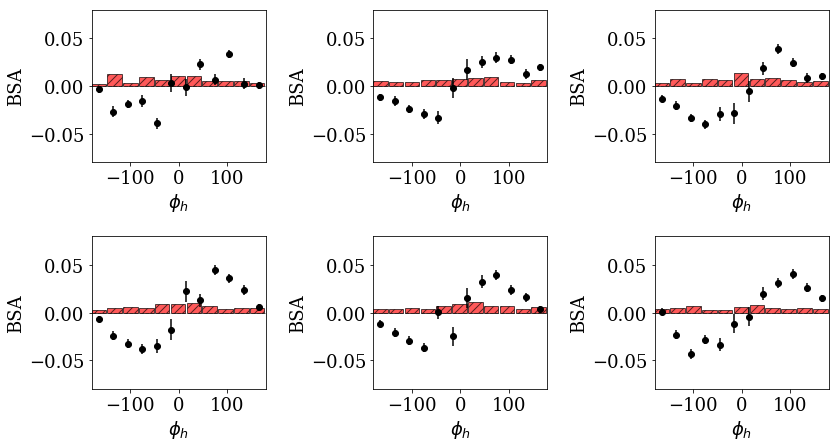

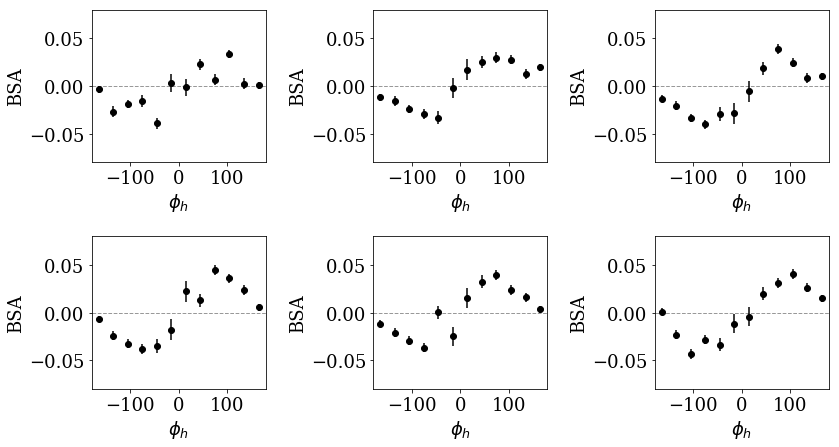

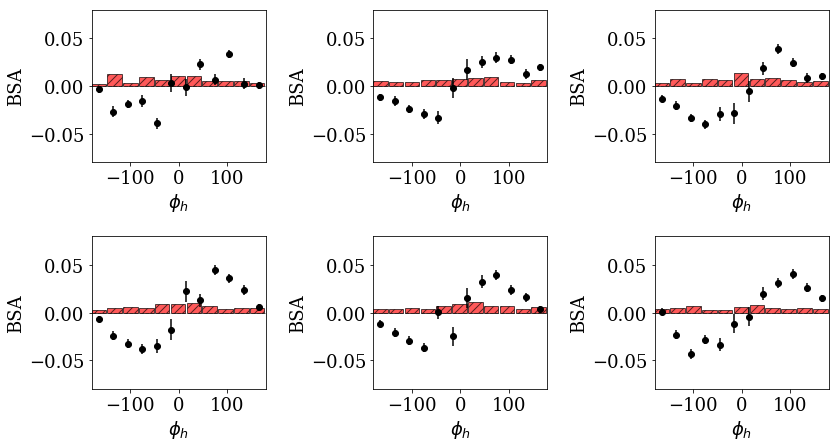

In [41]:
for axis in AXES:
    
    save_title = 'image/bsa_%s.pdf' % axis
    plot_results(results['nominal'], 'x')
    plt.savefig(save_title, bbox_inches='tight')

    save_title = 'image/bsa_%s_sys.pdf' % axis
    plot_results(results['nominal'], 'x', plot_sys=True)
    plt.savefig(save_title, bbox_inches='tight')

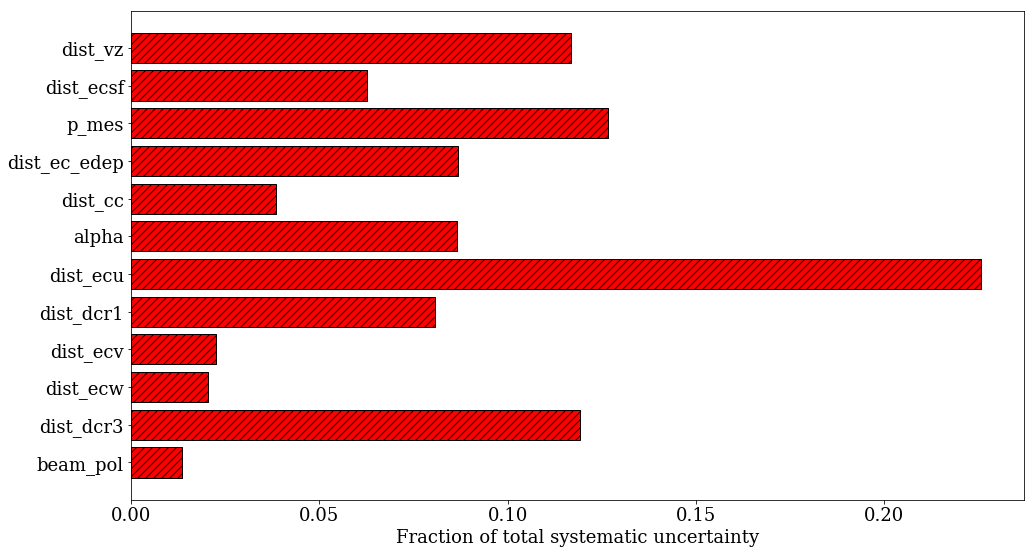

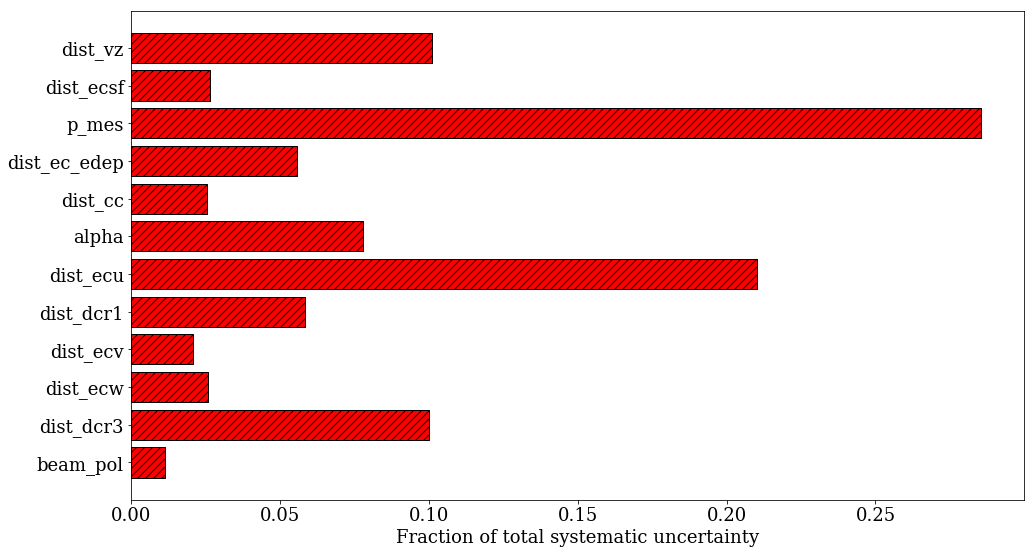

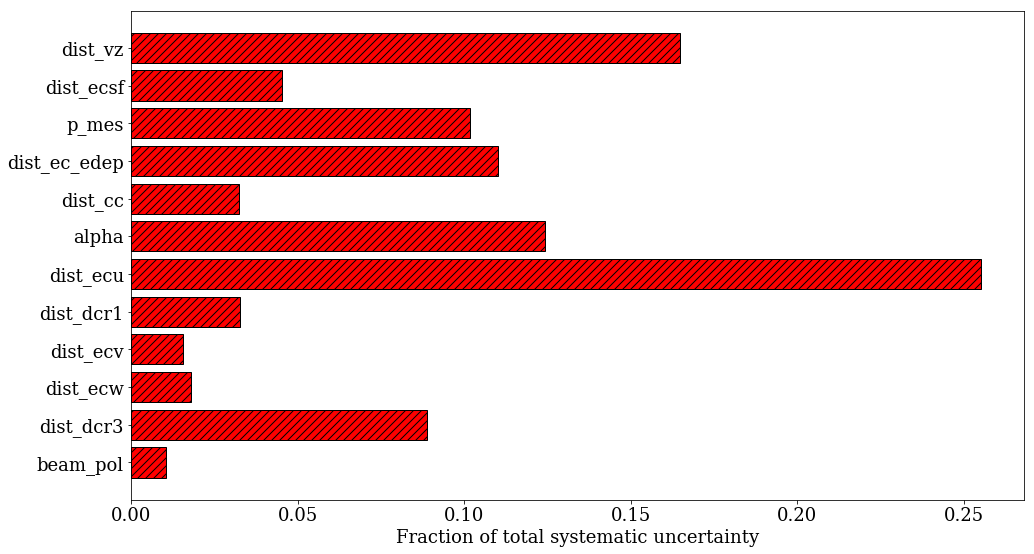

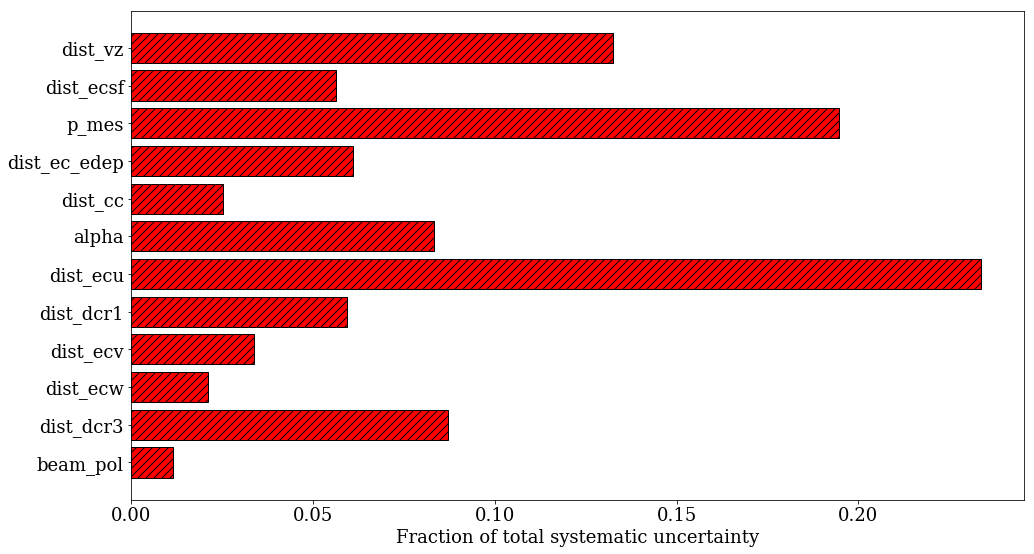

In [42]:
for axis in AXES:
    plot_sys_bar(results['nominal'], var_to_col, axis)
    save_title = 'image/systematic-bar-%s.pdf' % axis
    plt.savefig(save_title, bbox_inches='tight')

In [43]:
#plot_sys(results['nominal'], 'x')

These "shift" plots display the different results obtained by varying different analysis parameters ("cuts").  The horizontal band corresponds to the statistical error associated with the nominal value, with the "ideal" set of cuts.  The color of the band indicates the true/false status of whether a measurement has fallen outside of the statistical error band or not.

In [44]:
#plot_grid_shifts(results['nominal'], results['alpha'], 'z')

In [45]:
#plot_grid_shifts(results['nominal'], results['p_mes'], 'z')
#plt.savefig('image/variation-p_mes.pdf', bbox_inches='tight')

In [46]:
#plot_grid_shifts(results['nominal'], results['dist_vz'], 'z')

In [47]:
#plot_shifts(results['nominal'], results['dist_ecu'], 'x', 47)

In [48]:
#plot_2d_shifts(results['nominal'], results['dist_vz'], 'z')

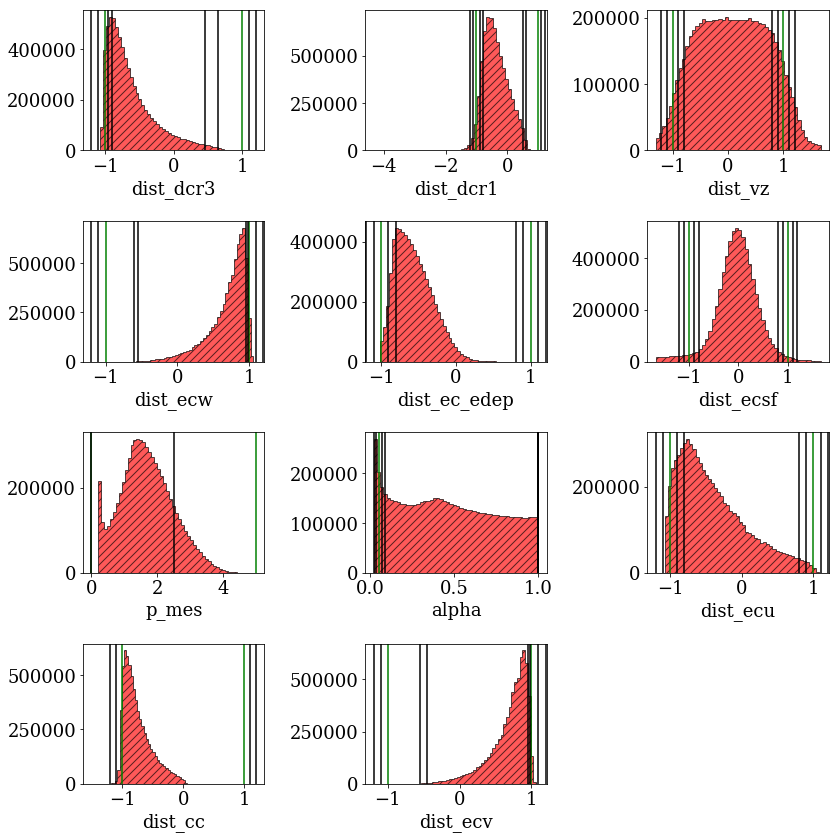

In [49]:
plot_variation_limits(data, variations)
#plt.savefig('image/variations.pdf', bbox_inches='tight')

In [50]:
#plot_subset_check(subset_scores)
#plt.savefig('image/subset_scores_k4.pdf', bbox_inches='tight')

In [51]:
#plot_momentum_check(p_results, 'q2', p_limits)

In [52]:
#scatter_two_results(p_results[0], p_results[1], 'x')

In [53]:
#plot_grid_helicity_check(results['nominal'], hel_results, 'z')

In [54]:
#plot_helicity_prob(hel_results[0], 'z')
#plt.savefig('image/random-helicity.pdf', bbox_inches='tight')

### Save Results
The results for this measurement, with systematic uncertainties, is saved in simple csv format for fitting in a different code (which as of this moment does not exist).

In [55]:
results['nominal'].to_csv('results/phi-dist.csv', index=False)